# Class Imbalance: Cost Sensitive Learning
* Most machine learning algorithms assume that all misclassification errors made by a model are equal. This is often not the case for imbalanced classification problems where missing a positive or minority class case is worse than incorrectly classifying an example from the negative or majority class. 
* Cost-sensitive learning is a subfield of machine learning that takes the costs of prediction errors (and potentially other costs) into account when training a machine learning model. It is a field of study that is closely related to the field of imbalanced learning that is concerned with classification on datasets with a skewed class distribution. As such, many conceptualizations and techniques developed and used for cost-sensitive learning can be adopted for imbalanced classification problems.
* The scikit-learn Python machine learning library provides examples of these cost-sensitive extensions via the **class weight** argument. 

## Cost-Sensitive Decision Trees
* Before we dive into the modification of decision trees for imbalanced classification, let’s first define an imbalanced classification dataset. We can use the **make_classification()** function to define a synthetic imbalanced two-class classification dataset. We will generate 10,000 examples with an approximate 1:100 minority to majority class ratio.

Counter({0: 9900, 1: 100})


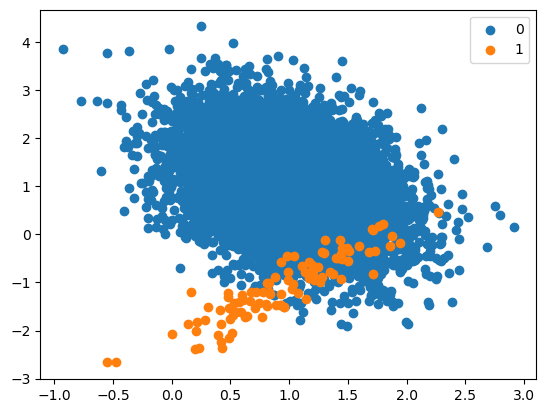

In [1]:
# Generate and plot a synthetic imbalanced classification dataset
%matplotlib inline
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=3)
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

### Baseline
* We can fit a **DecisionTreeClassifier** model on this dataset and evaluate the model using **repeated stratified k-fold cross-validation** with three repeats and 10 folds (30 in total).
* **The stratified k-fold cross-validation** will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.
* The ROC area under curve (AUC) measure can be used to estimate the performance of the model.

In [2]:
# evaluates a decision tree model on the imbalanced dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=3)
# define model
model = DecisionTreeClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1) # summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.736


* Running the example reports the average ROC AUC for the decision tree on the dataset over three repeats of 10-fold cross-validation (e.g. average over 30 different model evaluations).
* In this example, you can see that the model achieved a ROC AUC of about 0.73 to 0.74. This provides a **baseline** on this dataset before we apply cost-sensitive decision trees.

### Decision Trees for Imbalanced Classification
* The calculation of a purity measure involves calculating the probability of an example of a given class being misclassified by a split. Calculating these probabilities involves summing the number of examples in each class within each group. The splitting criterion can be updated to not only take the purity of the split into account, but also **be weighted by the importance of each class**.
* The scikit-learn Python machine learning library provides an implementation of the decision tree algorithm that supports class weighting. The **DecisionTreeClassifier** class provides the class weight argument that can be specified as a model hyperparameter. 
* A best practice for using the **class weighting** is to use the inverse of the class distribution present in the training dataset. For example, the class distribution of the test dataset is a 1:100 ratio for the minority class to the majority class. The invert of this ratio could be used with 1 for the majority class and 100 for the minority class.
* This heuristic is available directly by setting the class weight to **balanced**.

In [3]:
# decision tree with class weight on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=3)
# define model
model = DecisionTreeClassifier(class_weight='balanced')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1) # summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.749


## Cost-Sensitive Support Vector Machines
* The modification of SVM that weighs the margin proportional to the class importance is often referred to as weighted SVM, or cost-sensitive SVM. 

### Baseline

In [4]:
# fit a svm on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# define model
model = SVC(gamma='scale')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1) # summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.808


### Cost-Sensitive SVM
* The margin of SVM is softened to allow some points to appear on the wrong side of the decision boundary. This softening of the margin is controlled by a regularization hyperparameter referred to as the soft-margin parameter, capital-C (C).
* A value of C = 0 indicates a hard margin and no tolerance for violations of the margin. Small positive values allow some violation, whereas large integer values, such as 1, 10, and 100 allow for a much softer margin.
* The simplest and most common extension to SVM for imbalanced classification is to **weight the C value in proportion to the importance of each class**.
* Smaller weight: smaller C value, larger penalty for misclassified examples.
* Larger weight: larger C value, smaller penalty for misclassified examples.
* The scikit-learn Python machine learning library provides an implementation of the SVM algorithm that supports class weighting.
* A best practice for using the class weighting is to use the inverse of the class distribution present in the training dataset. For example, the class distribution of the test dataset is a 1:100 ratio for the minority class to the majority class. The invert of this ratio could be used with 1 for the majority class and 100 for the minority class.
* This heuristic is available directly by setting the class weight to **balanced**.

In [5]:
# svm with class weight on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# define model
model = SVC(gamma='scale', class_weight='balanced')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1) # summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.967


### Wow!

## Remark:
* Bagged Decision Trees, Random Forest, Stochastic Gradient Boosting such as XGBoost also offer hyperparameter arguments to take into account of cost-sensitive learning. You should also take those ensemble methods into account when you choose the best model for your imbalance problems.